'plt.figure(figsize=[30, 20])\n#plt.title("Mapa original")\nplt.imshow(mask_map, \'gray\', vmin=0, vmax=1)\nplt.savefig(\'mask_map.tiff\')\nplt.plot()\n\nplt.figure(figsize=[100, 40])\n#plt.title("Mapa original")\nplt.imshow(vaso_expandido_bin, \'gray\', vmin=0, vmax=1)\nplt.savefig(\'vaso_expandido_bin.tiff\')\nplt.plot()\n\nplt.figure(figsize=[30, 20])\n#plt.title("Mapa original")\nplt.imshow(vaso_sem_artefatos, \'gray\', vmin=0, vmax=1)\nplt.savefig(\'vaso_sem_artefatos.tiff\')\nplt.plot()\n\nplt.figure(figsize=[30, 20],facecolor=\'white\')\n#plt.title("Mapa original")\nplt.imshow(mapa_sem_artefatos, \'gray\', vmin=0, vmax=255)\nplt.savefig(\'mapa_sem_artefatos.png\')\nplt.plot()      \n\n\n\n""" plt.figure(figsize=[30, 20])\n#plt.title("Mapa original")\nplt.imshow(mapa_original, \'gray\', vmin=0, vmax=255)\n#plt.savefig(\'img.tiff\')\nplt.plot()"""\n\n#plt.figure(figsize=[100, 40])\n#plt.title("Mapa original")\n#plt.imshow(mapa_expandido_original, \'gray\', vmin=0, vmax=255)\n#plt.

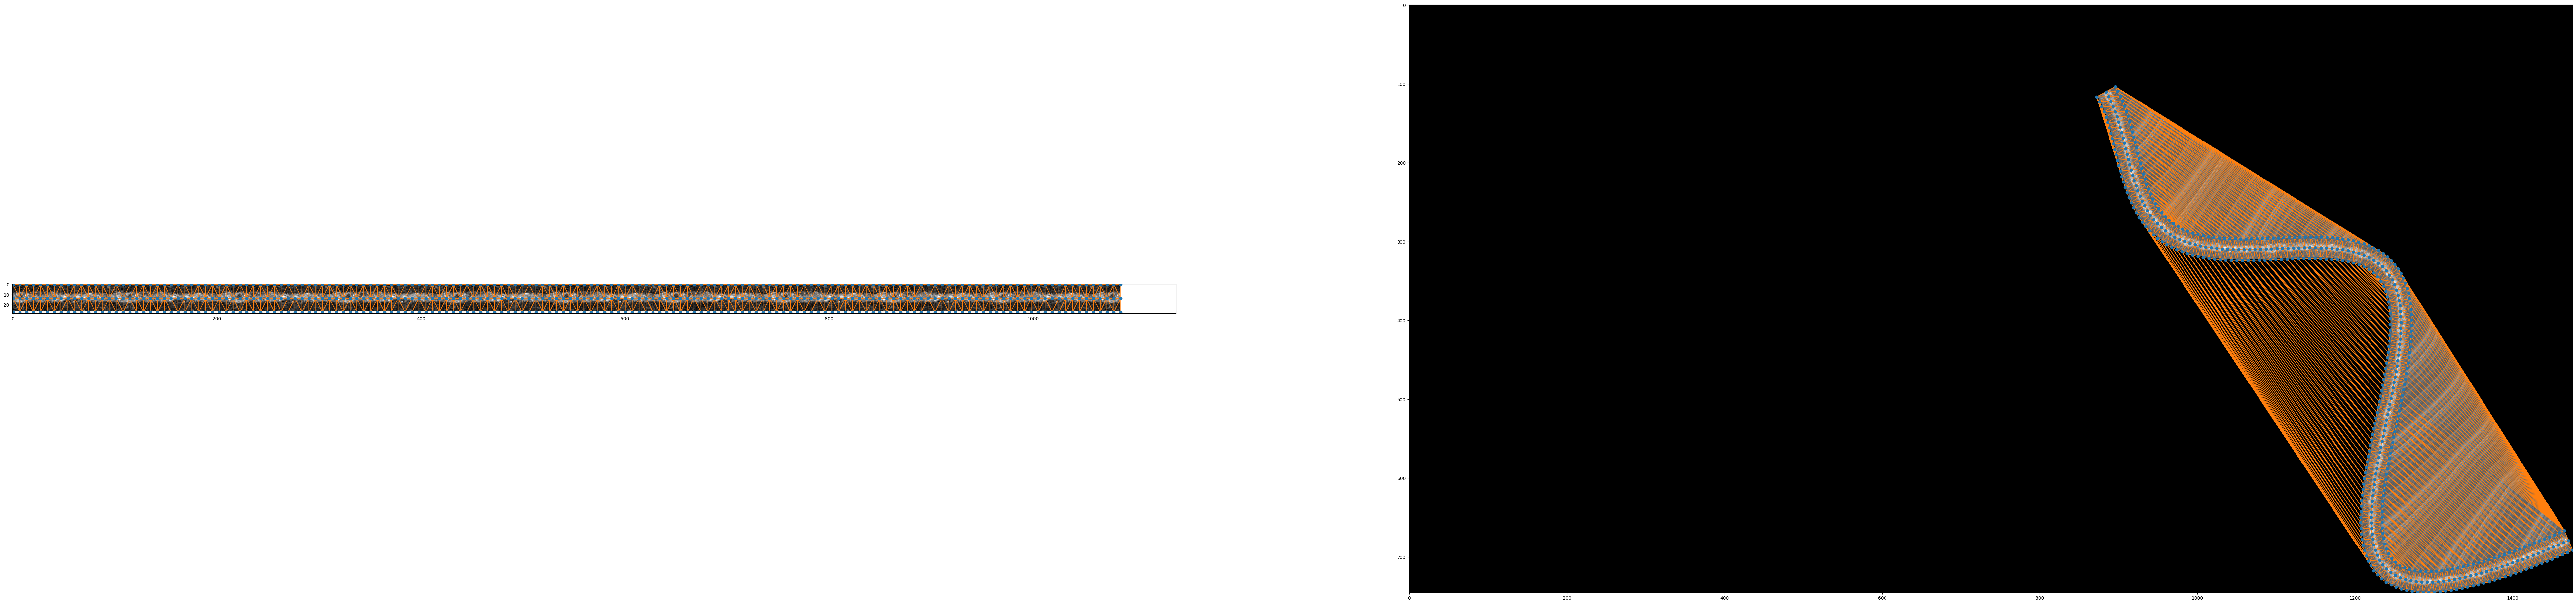

In [4]:
import pickle, os
import numpy as np
import sys
import skimage as ski
from pathlib import Path
from PIL import Image

from matplotlib import pyplot as plt

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

import geopandas as gpd
import background_generation as backgen

sys.path.insert(0, r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

from Funcoes_gerais import funcoes

#root_dir = f"/home/adriano/projeto_mestrado/modules"
root_dir = Path(r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

#dir linux
#root_dir ="/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images'

imag = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'

back_path = 'T-3 Weeks@Females@919 F@919-CTL-top-20X-01'

#Lendo o pickle e gerando o vessel_map
idx = 1
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
path = (pickle_dir + f'/{imag}_savedata1.pickle')
arquivo = pickle.load(open(path, 'rb'))
vessel_map = arquivo['vessel_model'].vessel_map
mapa_original = vessel_map.mapped_values

rows, cols = mapa_original.shape[0], mapa_original.shape[1]

altura = (rows/2) 

arquivo = f'{root_dir}/Artificial_Lines/tracados_bezier_maiores/img_savedata_13.json'

background_path = f'{root_dir}/Background/Mapas_gerados_artificialmente/{back_path}.tiff'
background = np.array(Image.open(f'{background_path}'))

medial_path = backgen.retorna_paths(arquivo)   

mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original,medial_path[1])

imagem_binaria_original = vessel_map.mapped_mask_values 
imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original) 

  
imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais) 
  
mapa_original_norm = backgen.normaliza(background,mapa_original,imagem_binaria_sem_artefatos,treshold=40)

distancia = int(medial_path[1])

vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,distancia)       
    
linha_offset_esquerda, linha_central, linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(medial_path[0],altura)  

#Criação das linhas à direita, centro e à esquerda a partir do traçado originado pelas curvas de beizier
dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)

#Execução do algoritmo que faz a transformação do mapa expandido
img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np,maior_tamanho)

tri = tform_out._tesselation 
tri_inv = tform_out._inverse_tesselation

plt.figure(figsize=[100,80])
ax = plt.subplot(121)
plt.imshow(img_proper, 'gray')
x, y = tri.points.T
ax.plot(x, y, 'o')
ax.triplot(x, y, tri.simplices.copy())

ax = plt.subplot(122)
plt.imshow(img_out, 'gray')
x, y = tri_inv.points.T
ax.plot(x, y, 'o')
ax.triplot(x, y, tri_inv.simplices.copy())

plt.savefig('delaunay.svg',format='svg')


#backgen.delaunay_plot(img_proper, img_out, tri, tri_inv)

mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
  
#Máscara do vaso
mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,medial_path[0],img_out)   

#Vaso binário rotacionado - NÃO ESTAVA SENDO USADO
#vaso_binario_rotacionado = criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)   

#Mapa sem artefatos
mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)

rows_art, cols_art = mapa_sem_artefatos.shape

#Vaso binário expandido e rotacionado VER AQUI
img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)

#Vaso binário rotacionado sem artefatos
vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)  

#mapa_sem_artefatos_transf = backgen.transf_map_dist2(mapa_sem_artefatos,mask_map,vaso_sem_artefatos,background)


'''plt.figure(figsize=[30, 20])
#plt.title("Mapa original")
plt.imshow(mask_map, 'gray', vmin=0, vmax=1)
plt.savefig('mask_map.tiff')
plt.plot()

plt.figure(figsize=[100, 40])
#plt.title("Mapa original")
plt.imshow(vaso_expandido_bin, 'gray', vmin=0, vmax=1)
plt.savefig('vaso_expandido_bin.tiff')
plt.plot()

plt.figure(figsize=[30, 20])
#plt.title("Mapa original")
plt.imshow(vaso_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.savefig('vaso_sem_artefatos.tiff')
plt.plot()

plt.figure(figsize=[30, 20],facecolor='white')
#plt.title("Mapa original")
plt.imshow(mapa_sem_artefatos, 'gray', vmin=0, vmax=255)
plt.savefig('mapa_sem_artefatos.png')
plt.plot()      



""" plt.figure(figsize=[30, 20])
#plt.title("Mapa original")
plt.imshow(mapa_original, 'gray', vmin=0, vmax=255)
#plt.savefig('img.tiff')
plt.plot()"""

#plt.figure(figsize=[100, 40])
#plt.title("Mapa original")
#plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=255)
#plt.savefig('img_expandida.tiff')
#plt.plot()




#img1 = Image.fromarray(mapa_original.astype(np.uint8))
#path = f'img.tiff'
#img = img1.save(path)'''


In [ ]:
print(mapa_original.shape)
print(mapa_expandido.shape)
print(medial_path[1])

### Plotando os pontos

In [ ]:
pontos_x = caminhos_transladados_interpolado[0][:,0]
pontos_y = caminhos_transladados_interpolado[0][:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'Caminhos transladados Interpolados' )

### Exibição do mapa normal


In [ ]:
import numpy as np

mapa = np.array(mapa_original)

rows, cols = mapa.shape[0], mapa.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

dst_array_np = backgen.retorna_dst_array_np(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho)

img_proper, img_out, new_src, new_dst, tform, _, _= backgen.transform_v2(src, dst_array_np, mapa)
backgen.plot(img_proper, img_out, new_src, new_dst, 60)

### Lendo o pickle e gerando o vessel_map e a imagem binária sem artefatos

In [ ]:
#import cv2
from PIL import Image
import matplotlib.pyplot as plt

img = np.array(Image.open(img_dir + f'/{imag}.tiff'))

path = (pickle_dir + f'/{imag}_savedata1.pickle')

arquivo = pickle.load(open(path, 'rb'))

vessel_map = arquivo['vessel_model'].vessel_map

mapa_original = vessel_map.mapped_values


imagem_binaria_original = vessel_map.mapped_mask_values

imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)

imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)


plt.figure(figsize=[10, 8])
plt.title("Imagem binária sem artefatos")
plt.imshow(imagem_binaria_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.plot()

### Expandir mapas

In [ ]:
maior_valor_interpolado = np.max(caminhos_transladados_interpolado[0])
mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original,maior_valor_interpolado)
mapa_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor_interpolado)
mask_mapa_expandido_bin = np.ones(mapa_expandido_bin.shape)

### Exibindo o Mapa Aumentado

In [ ]:
plt.figure(figsize=[10, 8])
plt.title("Mapa aumentado")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("Mapa binário aumentado")
plt.imshow(mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("map_mask_transf")
plt.imshow(mask_mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()

### Execução do Algoritmo com o Mapa Expandido

In [ ]:
rows, cols = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]


img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.transform_v2(src, dst_array_np, mapa_expandido_original)
backgen.plot(img_proper, img_out, new_src, new_dst,vmax=60)

### Criação da mask binária do mapa

In [ ]:
tam = len(new_dst)

div = tam//3

vetor_div =[div,div*2,div*3]

parte_direita = new_dst[0:vetor_div[0]]
parte_centro = new_dst[vetor_div[0]:vetor_div[1]]
parte_esquerda = new_dst[vetor_div[1]:vetor_div[2]]

lista_somada = np.concatenate((parte_esquerda, parte_direita[::-1]))
polygon = np.array(lista_somada)[:,::-1]
mask_map = ski.draw.polygon2mask(img_out.shape, polygon)
mask_map.astype(int)
mask_map_sq = mask_map.squeeze()
#mask_inv = mask[::-1]

# plt.imshow(mask, 'gray')
# mask_pil = Image.fromarray(mask.astype(np.uint8))
# mask_pil.save("imagem.tiff")

### Criação da máscara do vaso

In [ ]:
linha_minima = int(np.min(np.rint(vessel_map.path2_mapped)))
linha_maxima  = int(np.max(np.rint(vessel_map.path1_mapped)))

diametro_maximo_vaso = (linha_maxima-linha_minima)/2

linha_mask_central,linha_mask_esquerda,linha_mask_direita, max_tam = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],diametro_maximo_vaso)

dst_mask_np = backgen.retorna_dst_array_np(linha_mask_central,linha_mask_esquerda,linha_mask_direita, max_tam)

rows_bin, cols_bin = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

src_cols_bin = np.linspace(0, cols_bin, max_tam)
src_rows_bin = np.linspace(0, rows_bin, 3)
src_cols_bin, src_rows_bin = np.meshgrid(src_cols_bin,src_rows_bin)
src_bin = np.dstack([src_cols_bin.flat, src_rows_bin.flat])[0]


dst_mask_np -= new_origin

tam = len(dst_mask_np)

div = tam//3

vetor_div =[div,div*2,div*3]

parte_direita = dst_mask_np[0:vetor_div[0]]
parte_centro = dst_mask_np[vetor_div[0]:vetor_div[1]] 
parte_esquerda = dst_mask_np[vetor_div[1]:vetor_div[2]] 

lista_somada = np.concatenate((parte_esquerda, parte_direita[::-1]))
polygon = np.array(lista_somada)[:,::-1]
mask_vessel = ski.draw.polygon2mask(img_out.shape, polygon) # type: ignore
mask_vessel.astype(int)
mask_vessel_sq = mask_vessel.squeeze()

In [ ]:
plt.imshow(mask_vessel_sq, 'gray')

### Execução do Algoritmo com o Mapa Expandido - Binário

In [ ]:
rows_bin, cols_bin = mapa_expandido_bin.shape[0], mapa_expandido_bin.shape[1]

src_cols_bin = np.linspace(0, cols_bin, maior_tamanho)
src_rows_bin = np.linspace(0, rows_bin, 3)
src_cols_bin, src_rows_bin = np.meshgrid(src_cols_bin,src_rows_bin)
src_bin = np.dstack([src_cols_bin.flat, src_rows_bin.flat])[0]


img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, tform_out_bin, _, _ = backgen.transform_v2(src_bin, dst_array_np, mapa_expandido_bin)
backgen.plot(img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, vmax=1)

### Plotando os pontos alterados e aumentados

In [ ]:
pontos_x = new_dst[:,0]
pontos_y = new_dst[:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'New DST')

### Exibindo o mapa original e os modificados

In [ ]:
plt.figure(figsize=[10, 8])
plt.title("img_out")
plt.imshow(img_out, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("Mapa original expandido")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("img_out_bin")
plt.imshow(img_out_bin, 'gray', vmin=0, vmax=1)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("mask_map_sq")
plt.imshow(mask_map_sq, 'gray', vmin=0, vmax=1)
plt.plot()

### Retirar chifres

In [ ]:
img_out_sq = img_out.squeeze()

mapa_sem_artefatos = np.zeros(img_out_sq.shape)

for i in range(mapa_sem_artefatos.shape[0]):
    for j in range(mapa_sem_artefatos.shape[1]):
        if mask_map_sq[i, j] == True:  # Verifica se o pixel é branco na imagem booleana
            # Inserindo o pixel quando a máscara tem True
            mapa_sem_artefatos[i, j] = img_out_sq[i,j]

plt.figure(figsize=[10, 8])
plt.title("mapa_sem_artefatos")
plt.imshow(mapa_sem_artefatos, 'gray', vmin=0, vmax=60)
plt.plot()


In [ ]:
# img_out_bin_sq = img_out_bin.squeeze()

vaso_sem_artefatos = np.zeros(img_out_sq.shape)

for i in range(vaso_sem_artefatos.shape[0]):
    for j in range(vaso_sem_artefatos.shape[1]):
        if mask_vessel_sq[i, j] == True:  # Verifica se o pixel é branco na imagem booleana
            # Inserindo o pixel quando a máscara tem True
            vaso_sem_artefatos[i, j] = img_out_bin[i,j]

plt.figure(figsize=[10, 8])
plt.title("vaso_sem_artefatos")
plt.imshow(vaso_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.plot()

### Inserindo o mapa em um background criado artificialmente

In [ ]:

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{imag}.tiff'))

img_out_sq = img_out.squeeze()
#img_out_transf_sq = img_out_transf_bin.squeeze()

#Mergear
#fundo = backgen.estimate_background(img, label)

# img_out_sq = mapa transformado
# img_out_bin_sq = vaso binário transformado
# img_out_transf_bin_sq = mapa binário transformado

#img_out_bin_sq = img_out_bin.squeeze()

point = (50,50)
limiar = 30
background = back_artif
img_merged = backgen.inserindo_vaso_fundo2(mapa_sem_artefatos,vaso_sem_artefatos,background,point,limiar)

plt.figure(figsize=[20, 8])
plt.subplot(1,2,1)
plt.title("fundo com vaso")
plt.imshow(img_merged, 'gray', vmin=0, vmax=60)

plt.subplot(1,2,2)
plt.title("mapa_sem_artefatos")
plt.imshow(mapa_sem_artefatos, 'gray', vmin=0, vmax=60)



### Exibindo os triângulos de Delaunay

In [ ]:
from skimage.transform import PiecewiseAffineTransform, warp
#img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin, tform_transf_bin

tri = tform_transf_bin._tesselation 
tri_inv = tform_transf_bin._inverse_tesselation 
backgen.delaunay_plot(img_proper_transf_bin, img_out_transf_bin, tri, tri_inv)